# Predicting the Best Time to Go to the Gym

This project is for gym-goes or potential gym-goers who
hate getting to the gym only to find that it is so crowded that they
have to wait to use the machines you want. In this project, we will build a model that helps us predict the best time to the go to the gym and avoid crowds.

We will be analyzing the “Crowdedness at the Campus Gym” dataset, which contains historic information about how crowded the campus gym is on a given day and hour, as well as other specific information about the specific days. The dataset contains over 60,000 observations about how many people were at the gym on a particular day and time. It contains 11 columns that contain the following information:
* number_people: this is the number of people at the gym at each observation. This will be our target variable or label.
* date: a string value with the specific date and time information.
* timestamp: an integer (int), with the number of seconds since the start of the day (00:00).
* dayofweek: an integer (int). 0 is equal to Monday and 6 is equal to Sunday.
* is_weekend: a Boolean value defining if this observation happened during a weekend. 1 for yes, 0 for no.
* is_holiday: a Boolean value defining if the observation happened during a holiday. 1 for yes, 0 for no.
* temperature: a float, defining the temperature during the day of the observation in Fahrenheit.
* isstartof_semester: a Boolean defining if the observation happened in the first 2 weeks of a semester. 1 for yes, 0 for no.
* is_during_semester: a Boolean defining if the observation happened during the active semester. 1 for yes, 0 for no.
* month: an integer (int) defining the month of the year. 1 is equal to January, 12 is equal to December.
* hour: an integer (int) for the hour of the day from 0 to 23.

In [131]:
import warnings
warnings.simplefilter(action='ignore')

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import missingno as msno
import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

### Loading the Dataset
Let's load the dataset and conduct a preliminary review

In [132]:
df_orig = pd.read_csv('crowdness_gym_data.csv')

df = df_orig.copy()
df.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


In [133]:
print(f'The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.\n')

df.info()

The dataset contains 62184 rows and 11 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 62184 non-null  int64  
 10  hour                  62184 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB


A brief statistical capture of the numeric columns:

In [134]:
df.describe()

,number_people,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
count,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000
mean,29.072543,45799.437958,2.982504,0.282870,0.002573,58.557108,0.078831,0.660218,7.439824,12.236460
std,22.689026,24211.275891,1.996825,0.450398,0.050660,6.316396,0.269476,0.473639,3.445069,6.717631
min,0.000000,0.000000,0.000000,0.000000,0.000000,38.140000,0.000000,0.000000,1.000000,0.000000
25%,9.000000,26624.000000,1.000000,0.000000,0.000000,55.000000,0.000000,0.000000,5.000000,7.000000
50%,28.000000,46522.500000,3.000000,0.000000,0.000000,58.340000,0.000000,1.000000,8.000000,12.000000
75%,43.000000,66612.000000,5.000000,1.000000,0.000000,62.280000,0.000000,1.000000,10.000000,18.000000
max,145.000000,86399.000000,6.000000,1.000000,1.000000,87.170000,1.000000,1.000000,12.000000,23.000000


### Cleaning the dataset
We'll clean the date column and check for missing data and null values in the dataset.

In [135]:
df['date'] = pd.to_datetime(df['date'])
df['date'].sample(10)

60445    2017-02-25 09:09:23-08:00
16756    2016-02-02 16:30:13-08:00
60479    2017-02-25 15:24:32-08:00
27919    2016-05-21 08:21:10-07:00
28157    2016-05-23 00:03:31-07:00
42788    2016-09-05 15:22:28-07:00
24309    2016-04-21 18:20:15-07:00
24172    2016-04-20 08:30:17-07:00
43759    2016-09-12 17:03:24-07:00
42795    2016-09-05 16:32:41-07:00
Name: date, dtype: object

<AxesSubplot:>

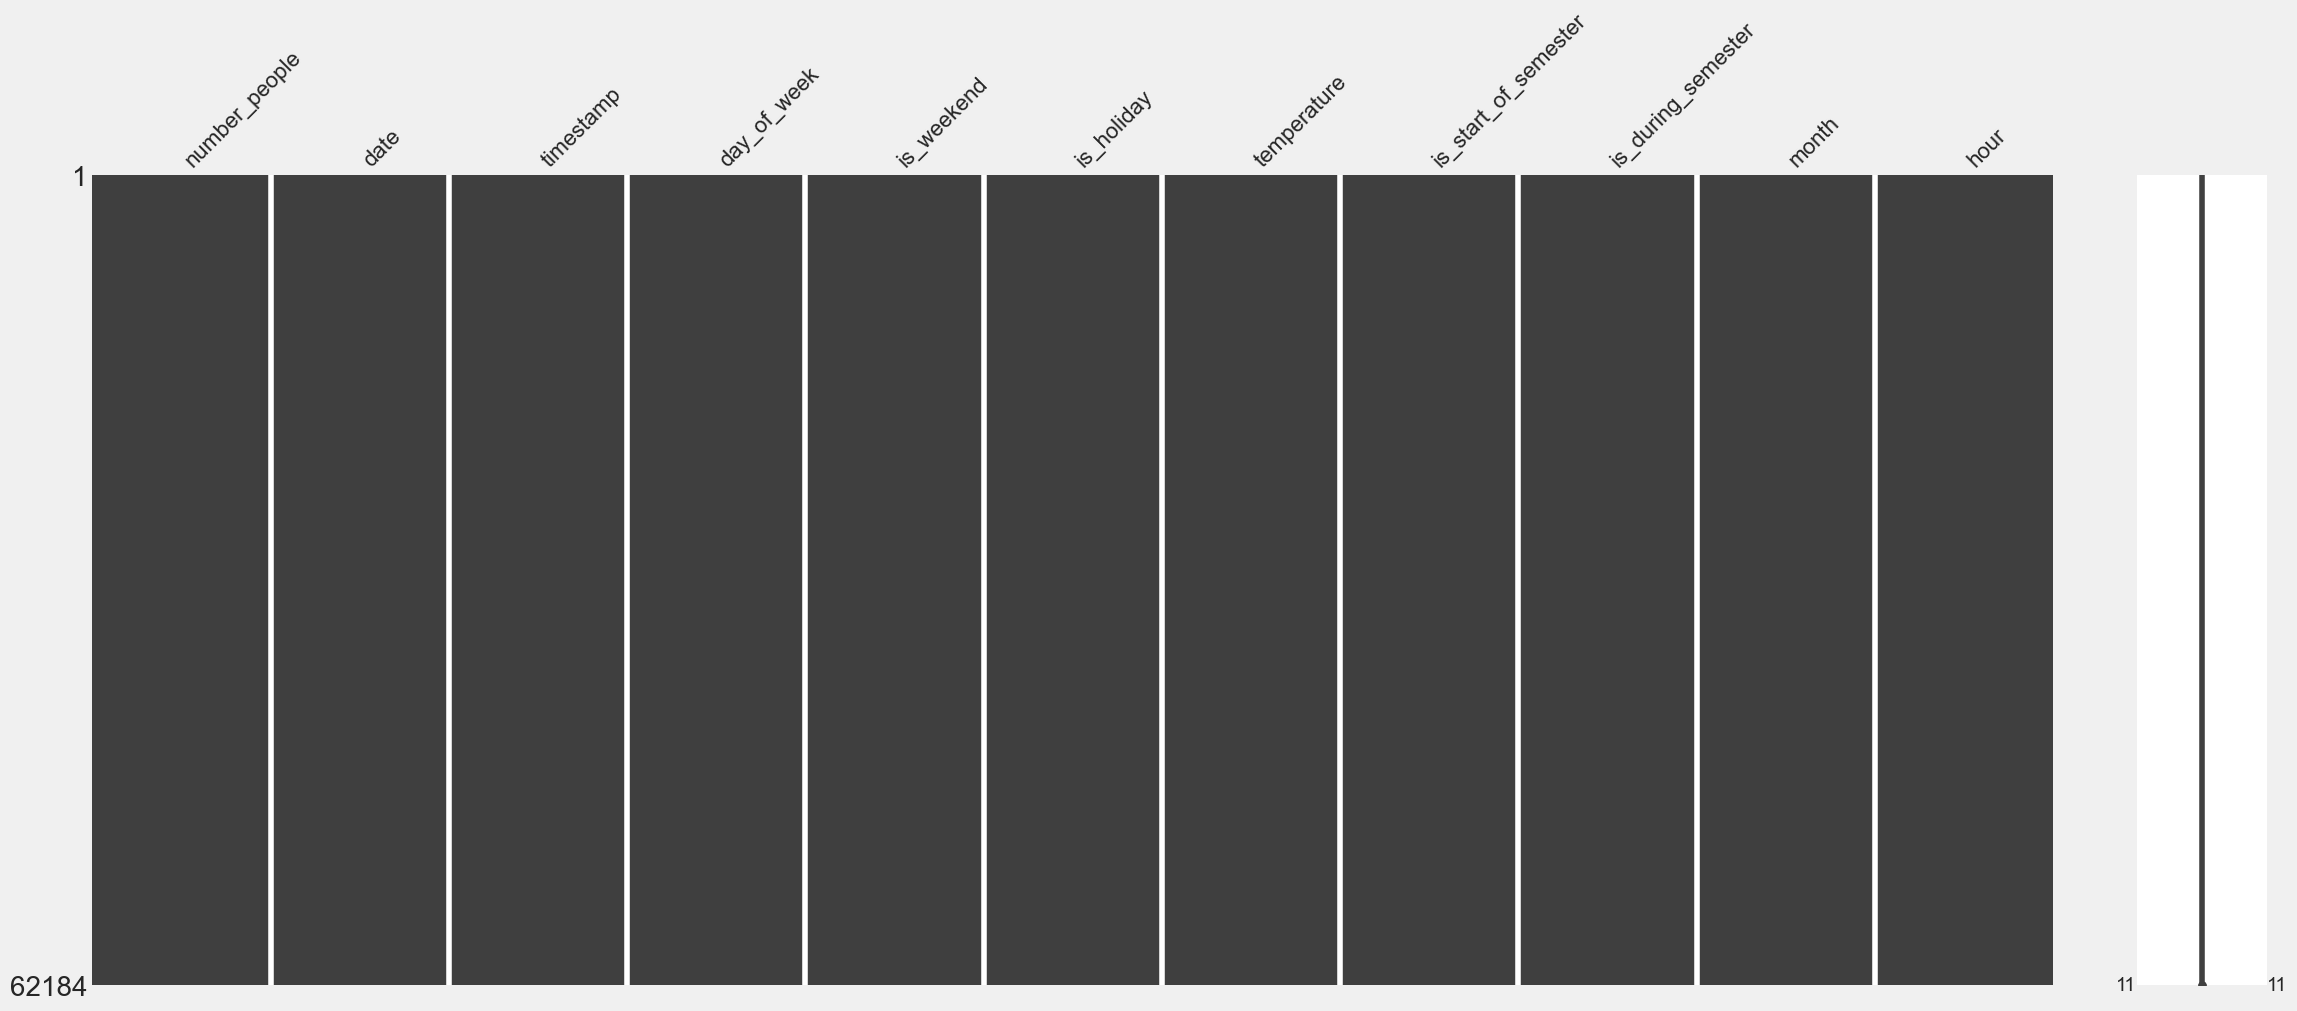

In [136]:
msno.matrix(df)

From this matrix, there's no missing data in dataset.

In [137]:
df.isnull().sum()

number_people           0
date                    0
timestamp               0
day_of_week             0
is_weekend              0
is_holiday              0
temperature             0
is_start_of_semester    0
is_during_semester      0
month                   0
hour                    0
dtype: int64

The is confirmed by the sum of null values across columns. Let's conduct some exploratory data analysis.

### Exploratory Data Analysis
Our dataset is made up of numeric columns. We'll visually analyze the data using heatmaps, histograms, density plots, bar charts and scatter plots. We'll be using the plotly.express module to plot more colorful charts.

First, let's analyze the correlation between numerical variables in the dataset.

In [138]:
df.corr()

,number_people,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
number_people,1.000000,0.550218,-0.162062,-0.173958,-0.048249,0.373327,0.182683,0.335350,-0.097854,0.552049
timestamp,0.550218,1.000000,-0.001793,-0.000509,0.002851,0.184849,0.009551,0.044676,-0.023221,0.999077
day_of_week,-0.162062,-0.001793,1.000000,0.791338,-0.075862,0.011169,-0.011782,-0.004824,0.015559,-0.001914
is_weekend,-0.173958,-0.000509,0.791338,1.000000,-0.031899,0.020673,-0.016646,-0.036127,0.008462,-0.000517
is_holiday,-0.048249,0.002851,-0.075862,-0.031899,1.000000,-0.088527,-0.014858,-0.070798,-0.094942,0.002843
temperature,0.373327,0.184849,0.011169,0.020673,-0.088527,1.000000,0.093242,0.152476,0.063125,0.185121
is_start_of_semester,0.182683,0.009551,-0.011782,-0.016646,-0.014858,0.093242,1.000000,0.209862,-0.137160,0.010091
is_during_semester,0.335350,0.044676,-0.004824,-0.036127,-0.070798,0.152476,0.209862,1.000000,0.096556,0.045581
month,-0.097854,-0.023221,0.015559,0.008462,-0.094942,0.063125,-0.137160,0.096556,1.000000,-0.023624
hour,0.552049,0.999077,-0.001914,-0.000517,0.002843,0.185121,0.010091,0.045581,-0.023624,1.000000


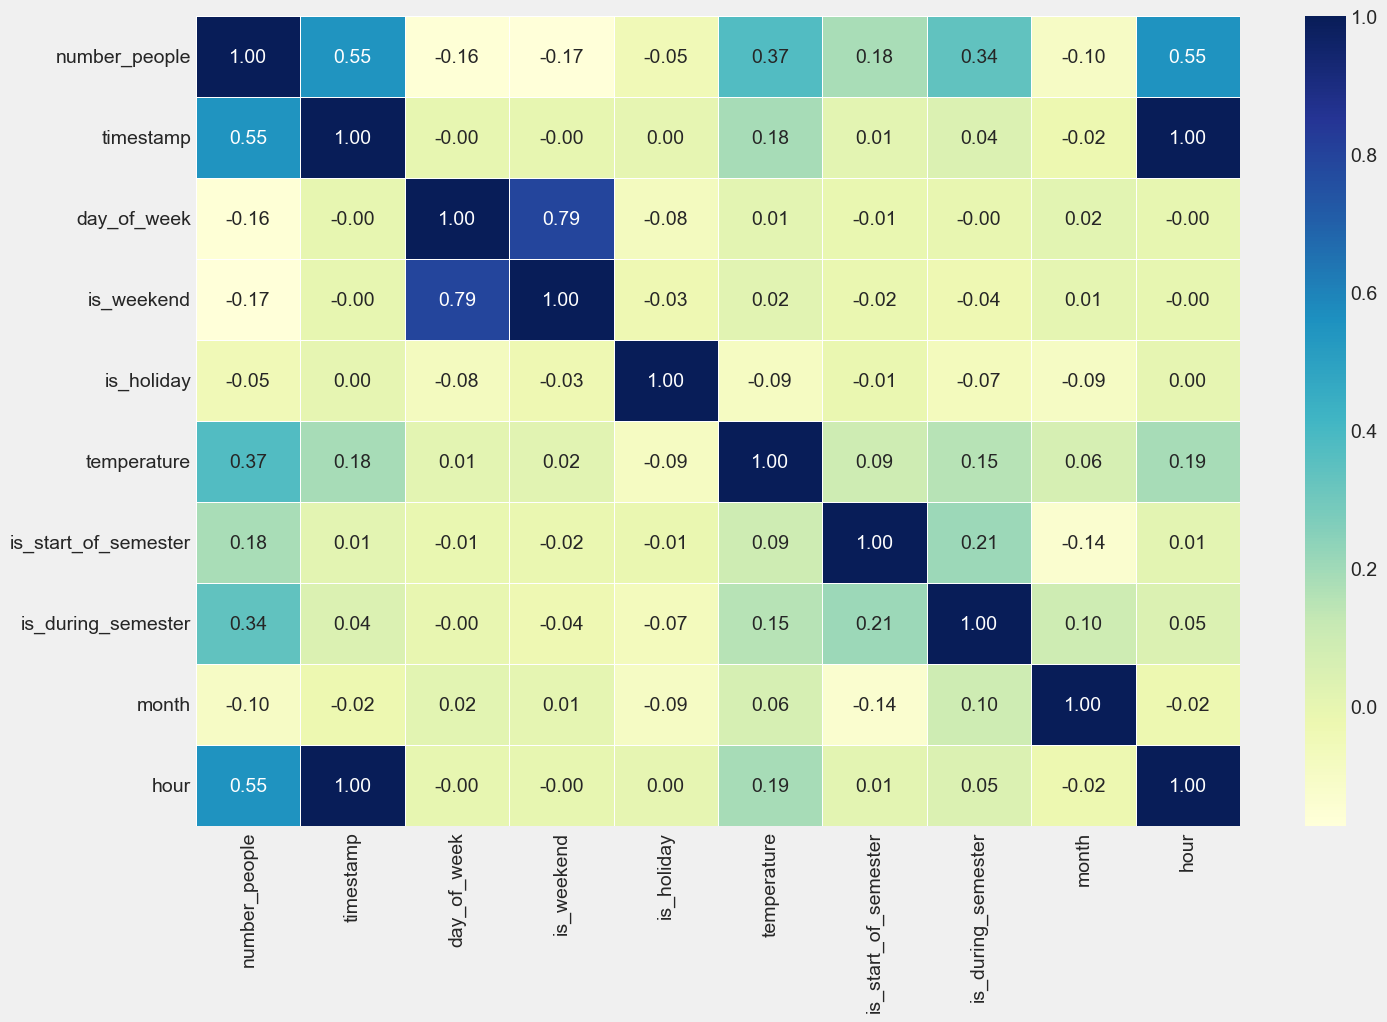

In [139]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(),
            annot=True,
            linewidths=0.5,
            fmt= ".2f",
            cmap="YlGnBu");

In [ ]:
fig = px.imshow(df.corr(), text_auto='.2f', aspect='auto')
fig.update_layout(width=525, height=550,
                  font=dict(size=10),
                  coloraxis_colorbar=dict(thickness=15, tickfont=dict(size=7)))
fig.show()

There a few significant correlations:
1. number of people and timestamp
2. number of people and hour
3. number of people and temperature
4. number of people and is during semester

##### Analyzing Feature Relationships
In order to determine the spread of the number of people in the gym, we'll plot a kernel density plot of the number of people in the gym throughout the dataset.

We'll also plot scatter charts to visually represent the relationship between the following variables:
* Temperature and Number of People
* Timestamp and Number of People
* Hour and Number of People

We'll chart boxplots for the following categorical features:
* is_start_of_semester
* is_during_semester
* is_holiday
* is_weekend

We'll use bar charts to determine the most popular hours,  days and months for crowded gyms.

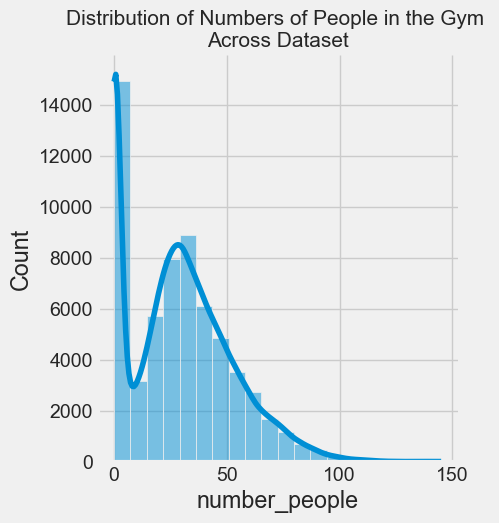

In [141]:
sns.displot(data=df, x='number_people', kde=True, bins=20)
plt.title('Distribution of Numbers of People in the Gym \nAcross Dataset', size=15)
plt.show()

In [142]:
fig = px.histogram(data_frame=df, x='number_people', nbins=20,
                   title='Distribution Count of People in the Gym')
fig.show()

In [ ]:
hist_data = [df['number_people']]
group_labels = ['Number of People'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels, bin_size=10)
fig.update_layout(title='Distribution of Numbers of People in the Gym')
fig.show()

Our density plots are right skewed, which means that the average is to the right of the median on the x-axis. From our df.describe() analysis, the average is 29 and the median is 28.

From our histogram and density plots, there are mostly under 10 people at the gym at any given time. However, the most frequent number of people in a gym at any given time is the under 30 people and under 40 people range. The latter range exceeds the median and average and is our threshold for a crowded gym.

Next, let's determine how temperature affects the number of people in a gym using a scatter plot.

In [ ]:
fig = px.scatter(df, x="temperature", y="number_people", color="is_weekend", title='Temperature vs. Number of People')
fig.update_layout(coloraxis_colorbar=dict(thickness=15))
fig.show()

There seems to be a positive linear relationship between temperature and number of people in the gym. As the temperature moves beyond 47 degrees Fahrenheit,  the number of people in gyms extend beyond our under 40 range. However, this relationship turns negative once temperatures exceed the 77 degrees Fahrenheit mark. Also, gyms are the fullest when temperatures are between 50 and 70, and it's a weekday.

Let's consider the relationship between timestamp and number of people. As noted above, timestamp is the number of seconds that has passed in the day since the start of the day at 00:00:00 hours.

In [ ]:
fig = px.scatter(df, x="timestamp", y="number_people", color="is_weekend", title='Timestamp vs. Number of People')
fig.update_layout(coloraxis_colorbar=dict(thickness=15))
fig.show()

From our scatter plot, on weekdays, gyms are fairly crowded during the first hour of the day, between 12 am and 1am. Gym count starts to exceed 70 people around 8 am and continues to rise until 11:30pm when it drops abruptly. However, the busiest hours in the gym at the hours of 6pm - 9pm on weekdays.

On weekends, the gym is the most crowded between the hours of 10am and 2pm, though not as crowded as peak periods on weekdays. Generally, gym usage on the weekend hovers around the 30 people mark.

This analysis is confirmed in the hour scatter plot below.

In [ ]:
fig = px.scatter(df, x="hour", y="number_people", color="is_weekend", title='Hour vs. Number of People')
fig.update_layout(coloraxis_colorbar=dict(thickness=15))
fig.show()

Let's chart the categorical variables against the number of people in the gym.

In [ ]:
fig = px.box(data_frame=df, x="is_start_of_semester",
             y="number_people",
             title='Number of People vs. Start of Semester',
             labels={'is_start_of_semester':'Start of Semester',
                     'number_people': 'Number of People'})
fig.update_xaxes(tickvals=[0, 1], ticktext=['no', 'yes']) # changes box label from 0 & 1 to no & yes
fig.show()

The gym is significantly more crowded at the start of the semester than later. This may reflect 'new semester resolutions'.

In [ ]:
fig = px.box(df, x="is_during_semester", y="number_people",
             title='Number of People vs. During Semester',
             labels={'is_during_semester':'During Semester',
                     'number_people': 'Number of People'})
fig.update_xaxes(tickvals=[0, 1], ticktext=['no', 'yes'])
fig.show()

The gym is more crowded during the semester than during the holidays. This is reflected in the box plot below.

In [ ]:
fig = px.box(df, x="is_holiday", y="number_people",
             title='Number of People vs.Holidays',
             labels={'is_holiday':'Holiday',
                     'number_people': 'Number of People'})
fig.update_xaxes(tickvals=[0, 1], ticktext=['no', 'yes'])
fig.show()

In [ ]:
fig = px.box(df, x="is_weekend", y="number_people",
             title='Number of People vs.Weekends',
             labels={'is_weekend':'Weekend', 'number_people': 'Number of People'})
fig.update_xaxes(tickvals=[0, 1], ticktext=['no', 'yes'])
fig.show()

The gym is significantly more crowded on weekdays than on weekends. From the bar plot below, Mondays to Wednesdays are the busiest days in the gym, with Tuesdays being peak gym days. Saturdays and Sundays are the days with the least number of people across the dataset period.

In [ ]:
df_days = df.groupby(by='day_of_week').agg({'number_people':np.sum})
days = [datetime.date(2001, 1, d).strftime('%A') for d in range(1, 8)]

fig = px.bar(df_days, x=days, y="number_people",
             color='number_people', title='Busiest Days at the Gym',
             labels={'x':'Days of the Week',
                     'number_people': 'Total Number of People'})
fig.update_layout(coloraxis_colorbar=dict(thickness=15,
                                          title_text='People Count',
                                          tickfont=dict(size=10)))
fig.show()

In [ ]:
df_months = df.groupby(by='month').agg({'number_people':np.sum})
months = [datetime.date(2000, m, 1).strftime('%B') for m in range(1, 13)]

fig = px.bar(df_months, y=months, x="number_people",
             color='number_people', title='Busiest Gym Month',
             labels={'y':'Months', 'number_people':'Total Number of People'}, orientation="h")
fig.update_layout(yaxis=dict(autorange="reversed"),
                  coloraxis_colorbar=dict(thickness=15,
                                          title_text='People Count',
                                          tickfont=dict(size=10)))
fig.show()

The busiest month in the gym is September. This reflects the box plot showing that the gym is busiest at the start of the semester. May to July, which are summer holidays, is the least crowded months for the gym.

In [ ]:
df_hours = df.groupby(by='hour').agg({'number_people':np.sum})

fig = px.bar(df_hours, y=df_hours.index, x="number_people",
             color='number_people', title='Busiest Time at the Gym',
             labels={'hour':'Hours', 'number_people': 'Total Number of People'}, orientation="h")
fig.update_layout(yaxis=dict(autorange="reversed"),
                  coloraxis_colorbar=dict(thickness=15,
                                          title_text='People Count',
                                          tickfont=dict(size=10)))
fig.show()

Peak gym hour is 5pm to 6pm.

In [154]:
df.head()

,number_people,date,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,2015-08-14 17:00:11-07:00,61211,4,0,0,71.76,0,0,8,17
1,45,2015-08-14 17:20:14-07:00,62414,4,0,0,71.76,0,0,8,17
2,40,2015-08-14 17:30:15-07:00,63015,4,0,0,71.76,0,0,8,17
3,44,2015-08-14 17:40:16-07:00,63616,4,0,0,71.76,0,0,8,17
4,45,2015-08-14 17:50:17-07:00,64217,4,0,0,71.76,0,0,8,17


#### Features for Modeling
Based on our EDA, we'll be using the following features for modeling:
* day_of week
* is_weekend
* is_holiday
* temperature
* is_start_of_semester
* is_during_semester
* month
* hour

### Preparing to Build our Model
In this section, we'll split the dataset into train and test sets, build our SGDRegressor model and train the model.

In [155]:
X = df.drop(columns=['number_people', 'date', 'timestamp'])
y = df['number_people']

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42)

In [157]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [158]:
sgdr = SGDRegressor(learning_rate="constant", eta0=1e-4, tol=1e-4, max_iter=10000)
sgdr.fit(X_train, y_train)

SGDRegressor(eta0=0.0001, learning_rate='constant', max_iter=10000, tol=0.0001)

In [159]:
y_pred = sgdr.predict(X_test)
y_pred[0:5]

array([20.19615976, 34.49480314, 29.55089906, 71.78422946,  7.96902295])

### Measure the Performance of the Model
Once the model is trained, it's time to measure its performance. For this project, use any of the previously loaded metrics: mean_square_error, mean_absolute_error or r2_score.

For mean squared error, the larger the number, the larger the error. The closer to 0, the better.
For mean absolute error, the larger the number, the larger the error.
For r2 score, the closer to 1, the better.

In [160]:
mse = mean_squared_error(y_test, y_pred)
mse

250.2545802903303

In [161]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse

15.819436788025365

In [162]:
mae = mean_absolute_error(y_test, y_pred)
mae

12.06659238704199

In [163]:
R2 = r2_score(y_test, y_pred)
R2

0.5150819621638921

### Visualize the Results
A good way to understand and evaluate our models is to visualize their results. To do that, we need to plot our model's predictions from the test data, from the actual results.

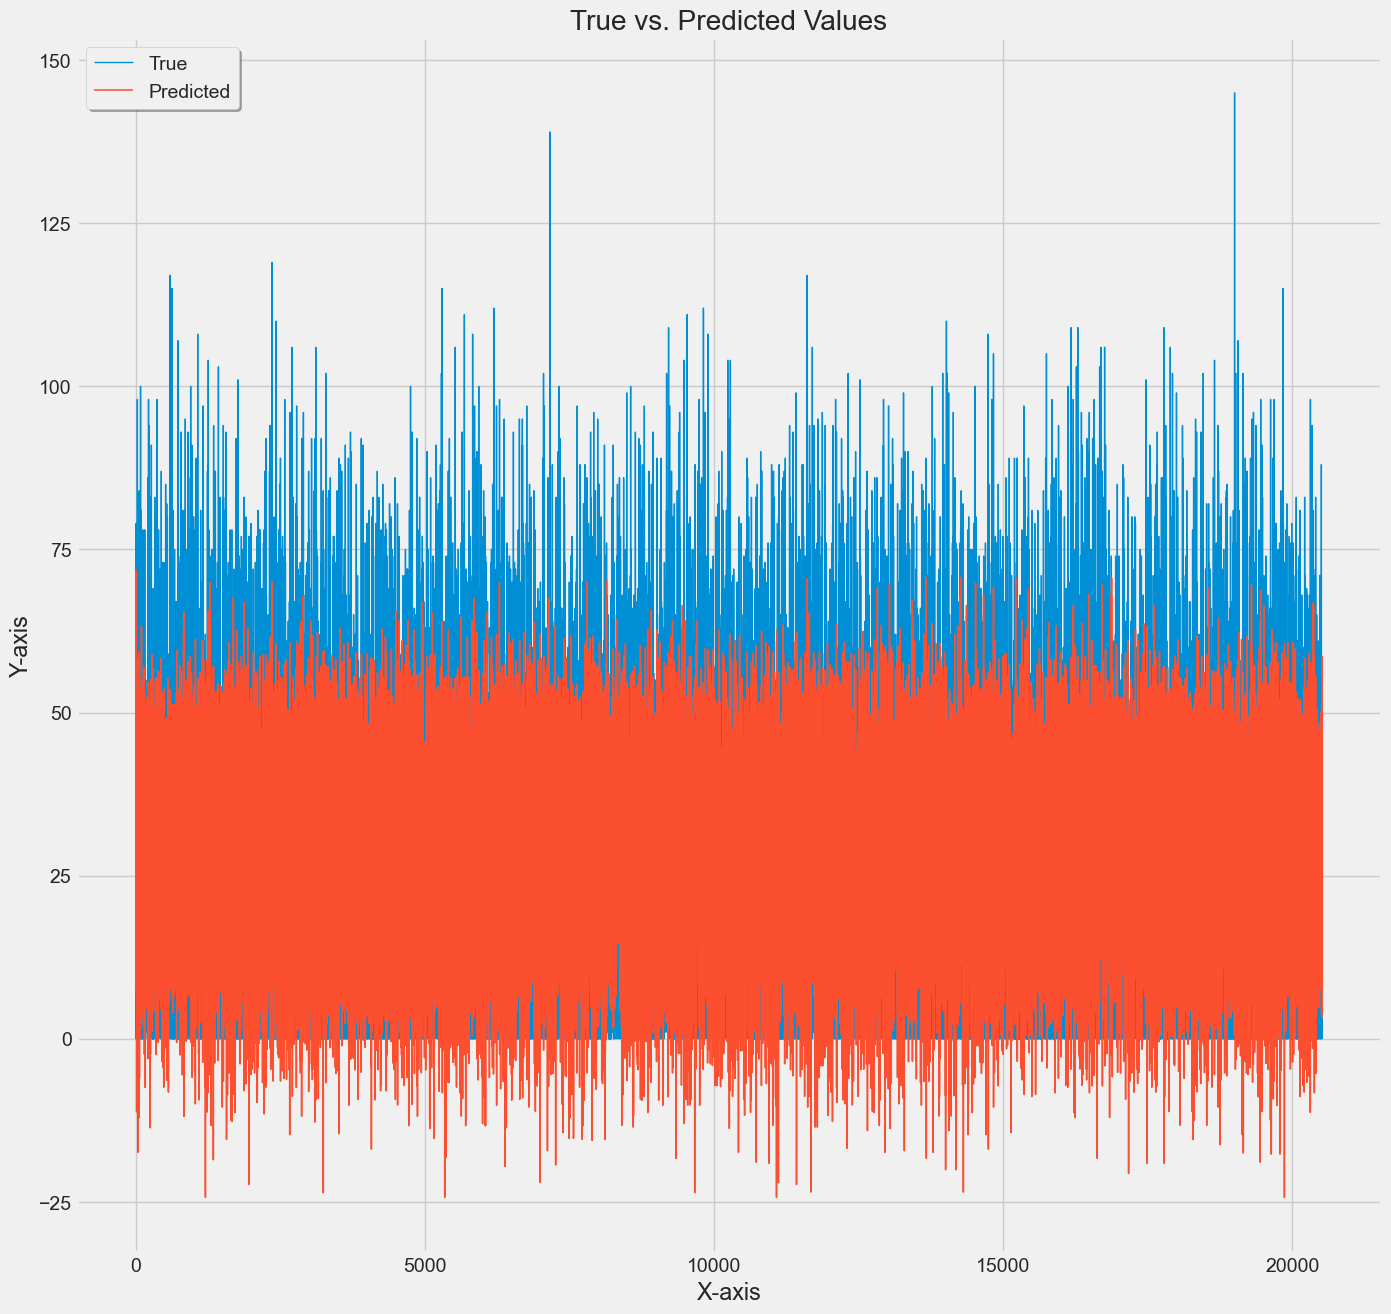

In [164]:
plt.figure(figsize=(15, 15))

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="True")
plt.plot(x_ax, y_pred, linewidth=1.1, label="Predicted")
plt.title("True vs. Predicted Values")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [ ]:
x_ax = range(len(y_test))
series_names = ["True", "Predicted"]
fig = px.line(x=x_ax, y=[y_test, y_pred],
              title='True vs. Predicted Values',
              labels={'value':'Y-axis', 'x': 'X-axis'})
fig.update_layout(legend_title="Values", legend=dict(font=dict(size=8)))
for idx, name in enumerate(series_names): # Change legend labels
    fig.data[idx].name = name
    fig.data[idx].hovertemplate = name
fig.show()

### Summarize Your Results
From our line plots above, the model find its easier to predict lower values but not higher ones. This means, it is more likely to underestimate the number of people in the gym given any predictor.

The MSE and MAE are on the high side, which affects the reliability of the model. However, the r-squared score gives the model a 51% chance of accuracy.

We may consider changing certain hyperparameters including loss, penalty and random_state in order to boost the accuracy of the model. However, the model's predictive accuracy is low and not very reliable.

In light of our EDA, weekends, holidays and anytime before 6am is a good time to avoid crowds at the gym.